In [1]:
# !wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv
# !curl -O https://lazyprogrammer.me/course_files/sp500_close.csv

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('./datasets/airline_passengers.csv', index_col='Month', parse_dates=True)

In [3]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
df.isna().sum()


Passengers    0
dtype: int64

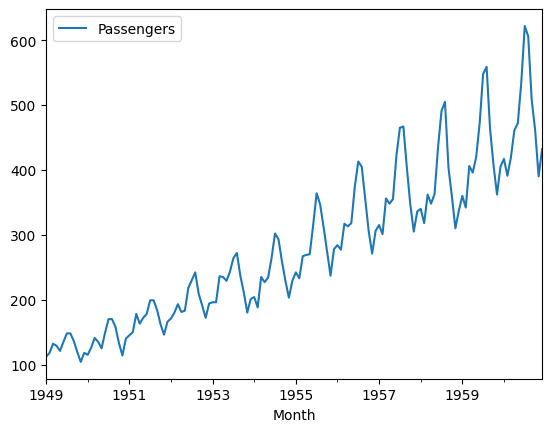

In [5]:
df.plot();

In [6]:
alpha = 0.4# we choose this parameter randomly this is a parameter that can be optimized

In [7]:
df['EWMA'] = df['Passengers'].ewm(alpha=alpha, adjust=False).mean()

In [8]:
df['EWMA'].head()

Month
1949-01-01    112.0000
1949-02-01    114.4000
1949-03-01    121.4400
1949-04-01    124.4640
1949-05-01    123.0784
Name: EWMA, dtype: float64

In [9]:
type(df['Passengers'].ewm(alpha=alpha, adjust=False))

pandas.core.window.ewm.ExponentialMovingWindow

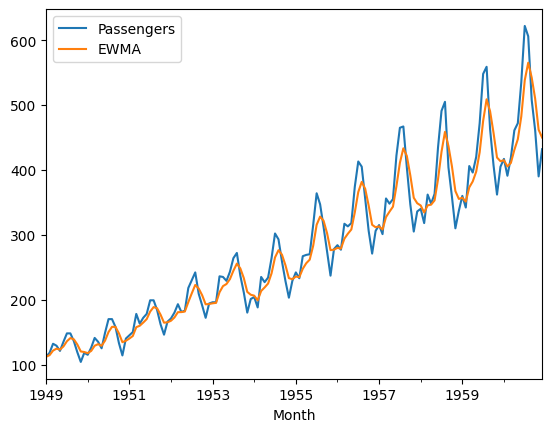

In [10]:
df.plot();

In [11]:
#the process made manually
manual_ewma = []
for x in df['Passengers'].to_numpy():
  if len(manual_ewma) > 0:
    xhat = alpha * x + (1 - alpha) * manual_ewma[-1]
  else:
    xhat = x
  manual_ewma.append(xhat)
df['Manual'] = manual_ewma

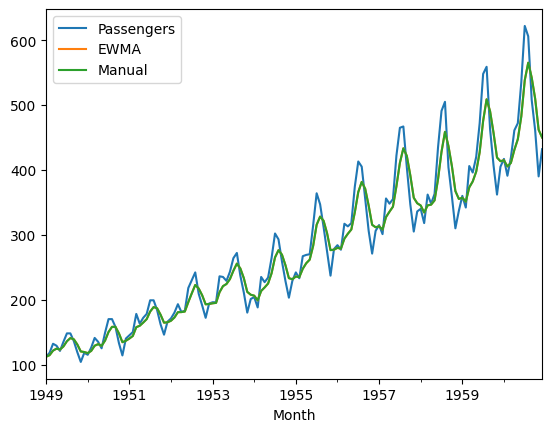

In [12]:
df.plot();

In [13]:
df.head()

,Passengers,EWMA,Manual
Month,,,
1949-01-01,112,112.0000,112.0000
1949-02-01,118,114.4000,114.4000
1949-03-01,132,121.4400,121.4400
1949-04-01,129,124.4640,124.4640
1949-05-01,121,123.0784,123.0784


In [14]:
df.drop('Manual', axis=1, inplace=True)

In [15]:
!pip install -U statsmodels

In [16]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing#Exponential Weighted Moving Average (EWMA)

In [17]:
ses = SimpleExpSmoothing(df['Passengers'])

C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [18]:
# link to offset aliases docs
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [19]:
df.index.freq = 'MS'

# Parámetro `initialization_method` en `SimpleExpSmoothing` de `statsmodels`

El parámetro `initialization_method` en el método `SimpleExpSmoothing` de `statsmodels` define cómo se inicializa el primer valor suavizado \( F_1 \), que es crucial para los cálculos posteriores de la serie suavizada. La elección de este método de inicialización afecta el pronóstico, ya que determina el punto de partida de la serie suavizada.

## Opciones de `initialization_method`

### 'estimated' (predeterminado en versiones más recientes de `statsmodels`):
- El valor inicial \( F_1 \) se estima como un parámetro durante el ajuste del modelo.
- Es la opción recomendada para mejorar la precisión del modelo, ya que optimiza el valor inicial en función de los datos.

### 'heuristic':
- El primer valor suavizado se establece utilizando una heurística (generalmente el primer valor de la serie).
- Es un método rápido, pero puede ser menos preciso en algunos casos.

### 'legacy-heuristic':
- Este es el método heredado de versiones anteriores de `statsmodels`.
- Establece el primer valor suavizado como el promedio de los primeros datos en la serie, y se utiliza principalmente para compatibilidad con versiones antiguas.

### 'known':
- Permite al usuario definir explícitamente el valor inicial de la serie suavizada.


In [20]:
ses = SimpleExpSmoothing(
    df['Passengers'],
    initialization_method='legacy-heuristic')

1. smoothing_level
Este parámetro controla el nivel de suavización exponencial, representado por el valor 
𝛼
α.
𝛼
α es un valor entre 0 y 1 que determina cuánto peso se asigna a los datos recientes en comparación con los datos anteriores:
Un valor de 
𝛼
α cercano a 1 otorga más peso a las observaciones recientes, lo que hace que la serie suavizada sea más reactiva a los cambios recientes.
Un valor de 
𝛼
α cercano a 0 otorga más peso a los valores suavizados anteriores, lo que da lugar a una serie más estable y menos sensible a las variaciones puntuales.
Si smoothing_level se establece en un valor específico (como alpha en tu ejemplo), entonces el modelo utilizará ese valor de 
𝛼
α en lugar de optimizarlo automáticamente.
2. optimized
Este parámetro controla si el modelo debe buscar el valor óptimo de 
𝛼
α y otros parámetros de ajuste.
Si optimized=True, el modelo intenta encontrar automáticamente el mejor valor de 
𝛼
α para minimizar el error de pronóstico (usando, por ejemplo, el método de mínimos cuadrados).
Si optimized=False, el modelo utiliza el valor proporcionado en smoothing_level sin hacer ninguna optimización adicional.

In [21]:
res = ses.fit(smoothing_level=alpha, optimized=False)

In [22]:
res

In [23]:
res.predict(start=df.index[0], end=df.index[-1])

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    114.400000
1949-04-01    121.440000
1949-05-01    124.464000
                 ...    
1960-08-01    538.237097
1960-09-01    565.342258
1960-10-01    542.405355
1960-11-01    509.843213
1960-12-01    461.905928
Freq: MS, Length: 144, dtype: float64

In [24]:
df['SES'] = res.predict(start=df.index[0], end=df.index[-1])

In [25]:
np.allclose(df['SES'], res.fittedvalues)

True

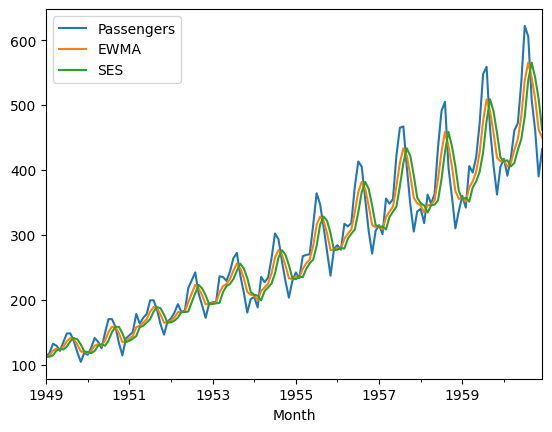

In [26]:
df.plot();


In [27]:
df.head

<bound method NDFrame.head of             Passengers        EWMA         SES
Month                                         
1949-01-01         112  112.000000  112.000000
1949-02-01         118  114.400000  112.000000
1949-03-01         132  121.440000  114.400000
1949-04-01         129  124.464000  121.440000
1949-05-01         121  123.078400  124.464000
...                ...         ...         ...
1960-08-01         606  565.342258  538.237097
1960-09-01         508  542.405355  565.342258
1960-10-01         461  509.843213  542.405355
1960-11-01         390  461.905928  509.843213
1960-12-01         432  449.943557  461.905928

[144 rows x 3 columns]>

In [28]:
df['SES-1'] = df['SES'].shift(-1)

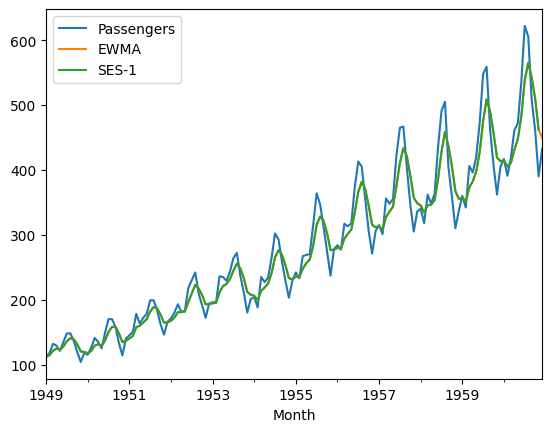

In [29]:
### No!
df[['Passengers', 'EWMA', 'SES-1']].plot();

In [30]:
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [31]:
ses = SimpleExpSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic')
res = ses.fit()

In [32]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

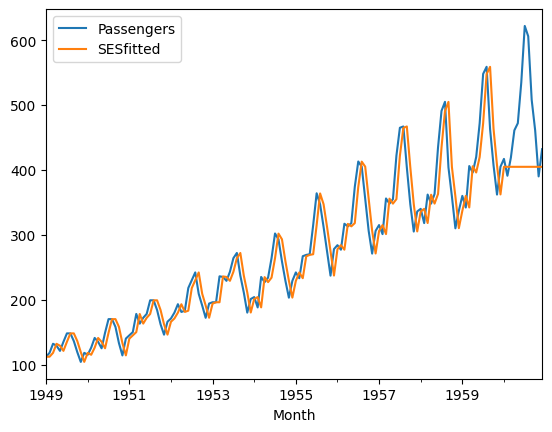

In [33]:
df.loc[train_idx, 'SESfitted'] = res.fittedvalues
df.loc[test_idx, 'SESfitted'] = res.forecast(N_test)
df[['Passengers', 'SESfitted']].plot();

In [34]:
res.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

nos damos cuenta que al final de la grafica quedo una linea recta porque no se especificio el alpha y se 

# Holt’s Linear Trend Model

In [35]:
from statsmodels.tsa.holtwinters import Holt

In [36]:
holt = Holt(
    df['Passengers'],
    initialization_method='legacy-heuristic')

In [37]:
res_h = holt.fit()

In [38]:
df['Holt'] = res_h.fittedvalues

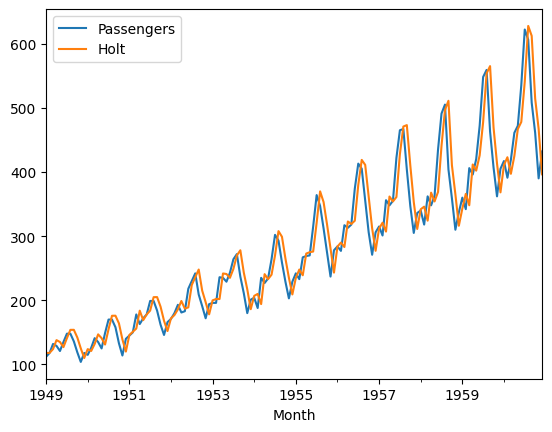

In [39]:
df[['Passengers', 'Holt']].plot();

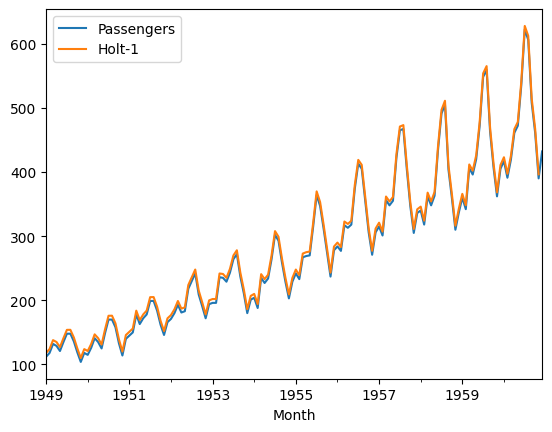

In [40]:
### No! no debemos hacer el shift de la serie para que concuerden perfectamente , mas adelante vamos a ver que necesitamos este shift
df['Holt-1'] = df['Holt'].shift(-1)
df[['Passengers', 'Holt-1']].plot();

In [43]:
holt = Holt(train['Passengers'], initialization_method='legacy-heuristic')
res_h = holt.fit()
df.loc[train_idx, 'Holt'] = res_h.fittedvalues

In [44]:
df.loc[test_idx, 'Holt'] = res_h.forecast(N_test)

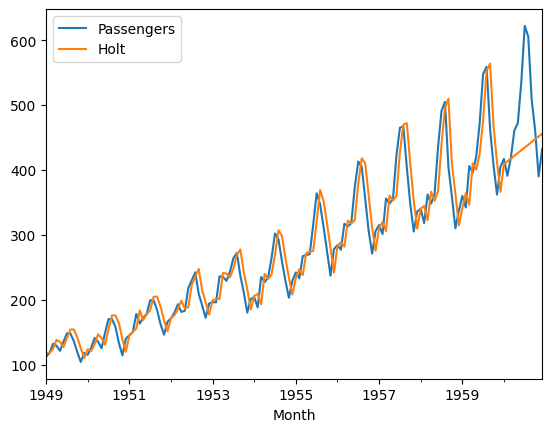

In [45]:
df[['Passengers', 'Holt']].plot();

## Holt-Winters Seasonal Model

In [51]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [52]:
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='add', seasonal_periods=12)
res_hw = hw.fit()

In [53]:
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues

In [54]:
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)

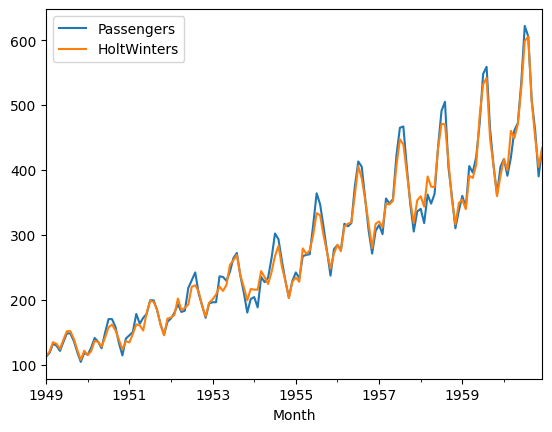

In [55]:
df[['Passengers', 'HoltWinters']].plot();

In [56]:
def rmse(y, t):
  return np.sqrt(np.mean((y - t)**2))

In [57]:
def mae(y, t):
  return np.mean(np.abs(y - t))

In [58]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 11.852990975608384
Test RMSE: 15.543111574921017


In [59]:
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE: 8.892129241474121
Test MAE: 10.438273613134896


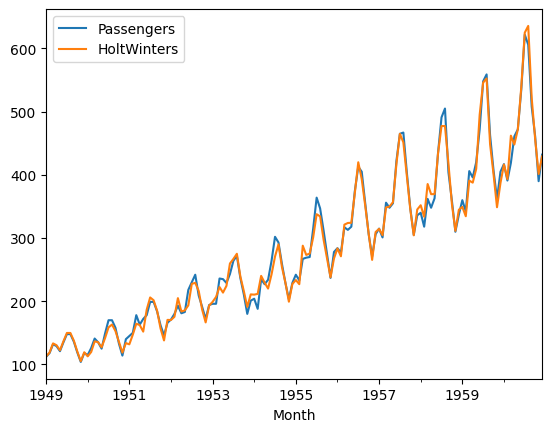

In [60]:
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='mul', seasonal_periods=12)
res_hw = hw.fit()
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers', 'HoltWinters']].plot();

In [61]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 10.153934838980446
Test RMSE: 16.53521274372282


In [62]:
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE: 7.5520526448052845
Test MAE: 10.68334156323617


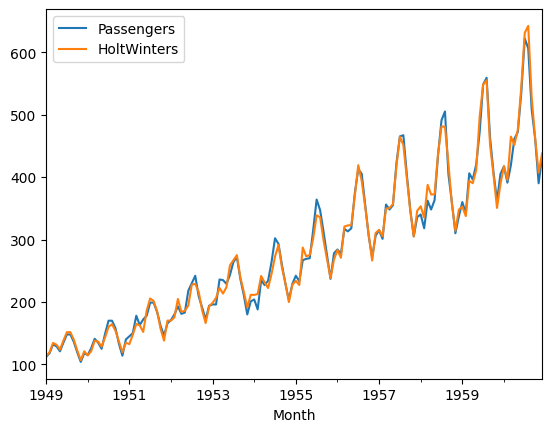

In [63]:
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='mul', seasonal='mul', seasonal_periods=12)
res_hw = hw.fit()
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers', 'HoltWinters']].plot();

In [64]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 9.887178133859093
Test RMSE: 19.102093666490106


In [65]:
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE: 7.408706879667877
Test MAE: 13.450514902523045
